In [1]:
# JM: 25 Oct 2020
# plots some sample EOSs (linear, toy nonlinear, TEOS-10)
# sections uses data output from NEMO ORCA12 (which has potential temperature and practical salinity)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean

# define some defaults
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r" # \"*_r\" is reverse of standard colour\n",
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

In [2]:
# subroutines

# dirty hack to get exponents and precision of a number
def get_exponent_precision(num, precision):
    out = []
    out.append(int(np.floor(np.log10(abs(num))))) # exponent
    out.append(round(num / float(10**int(np.floor(np.log10(abs(num))))), precision))
    
    return out

def sigmai_dep(CT, SA, p):
    """
    Compute the in-situ (or potential) density from CONSERVATIVE Temperature, 
    ABSOLUTE Salinity and pressure fields using the TEOS-10 EOS

    p can be a field (computed with subroutine p_from_z say) to get in-situ 
    density or can be a number p = p_ref, then it is a potential density 
    referenced to p_ref

    Adapted from the MATLAB GSW toolbox (http://www.TEOS-10.org)

    Inputs:
    CT             = Conservative Temperature      t        deg celsius
    SA             = Absolute Salinity             s        g / kg
    p              = (reference) pressure          p        dbar

    Returns:
    sigmai_dep_out = (potential density            rho      kg / m^3

    """
    # ensures that SA is non-negative.
    SA = abs(SA)

    # deltaS = 24
    sfac = 0.0248826675584615                 # sfac   = 1/(40*(35.16504/35)).
    offset = 5.971840214030754e-1             # offset = deltaS*sfac.

    x2 = sfac * SA
    xs = np.sqrt(x2 + offset)
    ys = CT * 0.025
    z  = p * 1e-4

    v000 =  1.0769995862e-3
    v001 = -6.0799143809e-5
    v002 =  9.9856169219e-6
    v003 = -1.1309361437e-6
    v004 =  1.0531153080e-7
    v005 = -1.2647261286e-8
    v006 =  1.9613503930e-9
    v010 = -1.5649734675e-5
    v011 =  1.8505765429e-5
    v012 = -1.1736386731e-6
    v013 = -3.6527006553e-7
    v014 =  3.1454099902e-7
    v020 =  2.7762106484e-5
    v021 = -1.1716606853e-5
    v022 =  2.1305028740e-6
    v023 =  2.8695905159e-7
    v030 = -1.6521159259e-5
    v031 =  7.9279656173e-6
    v032 = -4.6132540037e-7
    v040 =  6.9111322702e-6
    v041 = -3.4102187482e-6
    v042 = -6.3352916514e-8
    v050 = -8.0539615540e-7
    v051 =  5.0736766814e-7
    v060 =  2.0543094268e-7
    v100 = -3.1038981976e-4
    v101 =  2.4262468747e-5
    v102 = -5.8484432984e-7
    v103 =  3.6310188515e-7
    v104 = -1.1147125423e-7
    v110 =  3.5009599764e-5
    v111 = -9.5677088156e-6
    v112 = -5.5699154557e-6
    v113 = -2.7295696237e-7
    v120 = -3.7435842344e-5
    v121 = -2.3678308361e-7
    v122 =  3.9137387080e-7
    v130 =  2.4141479483e-5
    v131 = -3.4558773655e-6
    v132 =  7.7618888092e-9
    v140 = -8.7595873154e-6
    v141 =  1.2956717783e-6
    v150 = -3.3052758900e-7
    v200 =  6.6928067038e-4
    v201 = -3.4792460974e-5
    v202 = -4.8122251597e-6
    v203 =  1.6746303780e-8
    v210 = -4.3592678561e-5
    v211 =  1.1100834765e-5
    v212 =  5.4620748834e-6
    v220 =  3.5907822760e-5
    v221 =  2.9283346295e-6
    v222 = -6.5731104067e-7
    v230 = -1.4353633048e-5
    v231 =  3.1655306078e-7
    v240 =  4.3703680598e-6
    v300 = -8.5047933937e-4
    v301 =  3.7470777305e-5
    v302 =  4.9263106998e-6
    v310 =  3.4532461828e-5
    v311 = -9.8447117844e-6
    v312 = -1.3544185627e-6
    v320 = -1.8698584187e-5
    v321 = -4.8826139200e-7
    v330 =  2.2863324556e-6
    v400 =  5.8086069943e-4
    v401 = -1.7322218612e-5
    v402 = -1.7811974727e-6
    v410 = -1.1959409788e-5
    v411 =  2.5909225260e-6
    v420 =  3.8595339244e-6
    v500 = -2.1092370507e-4
    v501 =  3.0927427253e-6
    v510 =  1.3864594581e-6
    v600 =  3.1932457305e-5

    v = v000 + ( 
        xs * (v100 + xs * (v200 + xs * (v300 + xs * (v400 + xs * (v500 
      + v600 * xs))))) + ys * (v010 + xs * (v110 + xs * (v210 + xs * (v310 
      + xs * (v410 + v510 * xs)))) + ys * (v020 + xs * (v120 + xs * (v220 
      + xs * (v320 + v420 * xs))) + ys * (v030 + xs * (v130 + xs * (v230 
      + v330 * xs)) + ys * (v040 + xs * (v140 + v240*xs) + ys * (v050 
      + v150 * xs + v060 * ys))))) + z * (v001 + xs * (v101 + xs * (v201 
      + xs * (v301 + xs * (v401 + v501 * xs)))) + ys * (v011 + xs * (v111
      + xs * (v211 + xs * (v311 + v411 * xs))) + ys * (v021 + xs * (v121 
      + xs * (v221 + v321 * xs)) + ys * (v031 + xs * (v131 + v231 * xs) 
      + ys * (v041 + v141 * xs + v051 * ys)))) + z * (v002 + xs * (v102 
      + xs * (v202 + xs * (v302 + v402 * xs))) + ys * (v012 + xs * (v112 
      + xs * (v212 + v312 * xs)) + ys * (v022 + xs * (v122 + v222 * xs) 
      + ys * (v032 + v132 * xs + v042 * ys))) + z * (v003 + xs * (v103 
      + v203 * xs) + ys * (v013 + v113 * xs + v023 * ys) + z * (v004 
      + v104 * xs + v014 * ys + z * (v005 + v006 * z)))))
              )

    sigmai_dep_out = (1 / v) - 1000

    return sigmai_dep_out

def linearEOS(T_vec, S_vec, rho0=1027.0, T0=10.0, S0=35.0,
                           alp0=1.6550e-1, bet0=7.6554e-1):
    
    """
    linear equation of state, numbers taken from the NEMO model, but note that NEMO uses
          
           d_a = rho / rho0 - 1

    whereas I am going to plot

           rho = rho0 * (1 + d_a)

    so all my coefficients here are multiplied by a factor of rho0 and with the 
    more conventional units of e.g. [alpha] = K-1 instead of [alpha_before] = K-1 kg m-3
    """
    alp0 /= rho0
    bet0 /= rho0
    
    dens  = np.zeros((len(T_vec), len(S_vec)))
    for j in range(len(T_vec)):
        dens[j, :] = rho0 * (1 - alp0 * (T_vec[j] - T0) + bet0 * (S_vec[:] - S0))
        
    # output parameters in a dictionary
    params = {"alp0" : alp0, "bet0" : bet0}
        
    return params, dens

def toy_nonlinearEOS(T_vec, S_vec, rho0=1027.0, T0=10.0, S0=35.0,
                                   alp0=1.6550e-1, bet0=7.6554e-1,
                                   lam1 = 5.9520e-2,       # cabbeling coeff T^2
                                   lam2 = 5.4914e-4,       # cabbeling coeff S^2
                                   nu   = 2.4341e-3,       # cabbeling coeff T S
                                   mu1  = 1.4970e-4,       # thermobaric in T
                                   mu2  = 1.1090e-5,       # thermobaric in S
                                   z    = 0):
    """
    toy nonlinear equation of state from Vallis (2006), numbers taken from the NEMO model, 
    but note that NEMO uses
    
           d_a = rho / rho0 - 1

    whereas I am going to plot

           rho = rho0 * (1 + d_a)

    so some of my coefficients here are multiplied by a factor of rho0 and with the 
    more conventional units of e.g. [alpha] = K-1 instead of [alpha_before] = K-1 kg m-3
    """
    alp0 /= rho0
    bet0 /= rho0
    nu   /= rho0
    
    dens  = np.zeros((len(T_vec), len(S_vec)))
    for j in range(len(T_vec)):
        Ta = T_vec[j] - T0
        Sa = S_vec[:] - S0
        dens[j, :] =rho0 * (1 - alp0 * (1.0 + 0.5 * lam1 * Ta + mu1 * z) * Ta 
                              + bet0 * (1.0 - 0.5 * lam2 * Sa - mu2 * z) * Sa
                              - nu * Ta * Sa)
        
    # output parameters in a dictionary
    params = {"alp0" : alp0, "bet0" : bet0, 
              "lam1" : lam1, "lam2" : lam2,
              "nu"   : nu,
              "mu1"  : mu1,  "mu2"  : mu2,
              "z"    : 0}
    return params, dens

# note: rho0 chosen here to get rough agreement with TEOS10 (1 kg m^-3 difference with rho0 = 1026)

outputted files


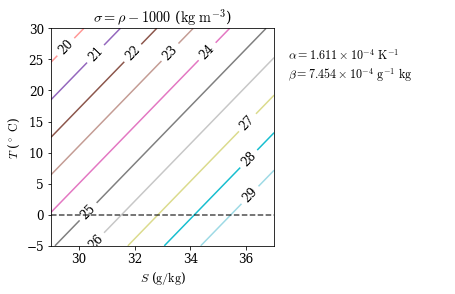

In [3]:
# linear equation of state

T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)
params, dens_lin = linearEOS(T_vec, S_vec)
params, dens_nonlin = toy_nonlinearEOS(T_vec, S_vec, mu1=0, mu2=0) # turn off thermobaric stuff

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
lines = ax.contour(S_vec, T_vec, dens_lin - 1000, 
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
temp = get_exponent_precision(params["alp0"], 3)
ax.text(37.5, 25, r"$\alpha = %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["bet0"], 3)
ax.text(37.5, 22, r"$\beta = %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
#cheap hack to made bbox_inches option work and generate diagrams of same sizes with below
temp = get_exponent_precision(params["nu"], 3)
ax.text(37.5, 13, 
        r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]),
       color="w")

plt.savefig(f"../lec06/figures/linear_EOS.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


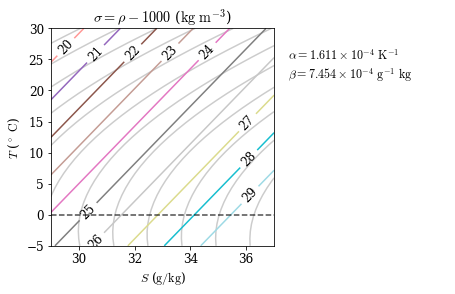

In [4]:
# linear equation of state

T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)
params, dens_lin = linearEOS(T_vec, S_vec)
params, dens_nonlin = toy_nonlinearEOS(T_vec, S_vec, mu1=0, mu2=0) # turn off thermobaric stuff
dens = np.zeros((len(T_vec), len(S_vec)))
for j in range(len(T_vec)):
    dens[j, :] = sigmai_dep(T_vec[j], S_vec, 0)

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.contour(S_vec, T_vec, dens, 
           levels=np.arange(15, 30), colors="k", alpha=0.2)
lines = ax.contour(S_vec, T_vec, dens_lin - 1000, 
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
temp = get_exponent_precision(params["alp0"], 3)
ax.text(37.5, 25, r"$\alpha = %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["bet0"], 3)
ax.text(37.5, 22, r"$\beta = %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
#cheap hack to made bbox_inches option work and generate diagrams of same sizes with below
temp = get_exponent_precision(params["nu"], 3)
ax.text(37.5, 13, 
        r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]),
       color="w")

plt.savefig(f"../lec06/figures/linear_EOS_vs_TEOS10.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


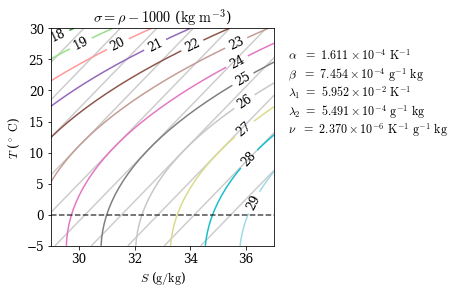

In [5]:
# toy nonlinear equation of state from Vallis (2006)

T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)
params, dens_lin = linearEOS(T_vec, S_vec)
params, dens_nonlin = toy_nonlinearEOS(T_vec, S_vec, mu1=0, mu2=0) # turn off thermobaric stuff

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.contour(S_vec, T_vec, dens_lin - 1000, 
           levels=np.arange(15, 30), colors="k", alpha=0.2)
lines = ax.contour(S_vec, T_vec, dens_nonlin - 1000, 
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
temp = get_exponent_precision(params["alp0"], 3)
ax.text(37.5, 25, r"$\alpha$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["bet0"], 3)
ax.text(37.5, 22, r"$\beta$  $=$ $ %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["lam1"], 3)
ax.text(37.5, 19, r"$\lambda_1$ $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["lam2"], 3)
ax.text(37.5, 16, r"$\lambda_2$ $=$ $ %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["nu"], 3)
ax.text(37.5, 13, r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))

plt.savefig(f"../lec06/figures/toy_nonlinear_EOS.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


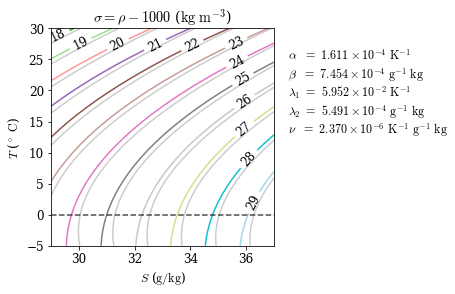

In [6]:
# toy nonlinear equation of state from Vallis (2006)

T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)
dens = np.zeros((len(T_vec), len(S_vec)))
for j in range(len(T_vec)):
    dens[j, :] = sigmai_dep(T_vec[j], S_vec, 0)
params, dens_nonlin = toy_nonlinearEOS(T_vec, S_vec, mu1=0, mu2=0) # turn off thermobaric stuff

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
lines = ax.contour(S_vec, T_vec, dens,   # already has the 1000 taken off
                   levels=np.arange(15, 30), colors="k", alpha=0.2)
lines = ax.contour(S_vec, T_vec, dens_nonlin - 1000, 
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
temp = get_exponent_precision(params["alp0"], 3)
ax.text(37.5, 25, r"$\alpha$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["bet0"], 3)
ax.text(37.5, 22, r"$\beta$  $=$ $ %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["lam1"], 3)
ax.text(37.5, 19, r"$\lambda_1$ $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["lam2"], 3)
ax.text(37.5, 16, r"$\lambda_2$ $=$ $ %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
temp = get_exponent_precision(params["nu"], 3)
ax.text(37.5, 13, r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))

plt.savefig(f"../lec06/figures/toy_nonlinear_EOS_vs_TEOS10.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


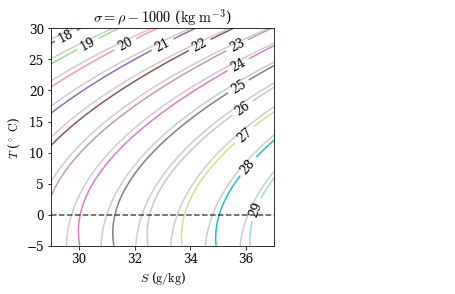

In [7]:
# using TEOS-10 75 term formula (from Fabien's code)
T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)
dens = np.zeros((len(T_vec), len(S_vec)))
for j in range(len(T_vec)):
    dens[j, :] = sigmai_dep(T_vec[j], S_vec, 0)
params, dens_nonlin = toy_nonlinearEOS(T_vec, S_vec, mu1=0, mu2=0) # turn off thermobaric stuff

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.contour(S_vec, T_vec, dens_nonlin - 1000, 
           levels=np.arange(15, 30), colors="k", alpha=0.2)
lines = ax.contour(S_vec, T_vec, dens,   # already has the 1000 taken off
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
#cheap hack to made bbox_inches option work and generate diagrams of same sizes with below
temp = get_exponent_precision(params["nu"], 3)
ax.text(37.5, 13, 
        r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]),
       color="w")

plt.savefig(f"../lec06/figures/TEOS10_EOS.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

In [4]:
# cartopy puts things on maps by transforming data co-ordinates etc
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

# do some plots with WOA13 data
data_dir = "/home/jclmak/data/WOA13/"

ds = xr.open_dataset(data_dir + "salinity_WOA13_decav_Reg1L46_clim.nc")
lon  = ds["lon"].data
lat  = ds["lat"].data
z    = -ds["lev"].data
soce = ds["vosaline"].mean(dim="time")

ds = xr.open_dataset(data_dir + "temperature_WOA13_decav_Reg1L46_clim.nc")
toce = ds["votemper"].mean(dim="time")

ds = xr.open_dataset(data_dir + "GRIDONE_2D.nc")
bathy = ds["elevation"]

cmap = cmocean.cm.curl.reversed()
pcarree = ccrs.PlateCarree()

outputted files


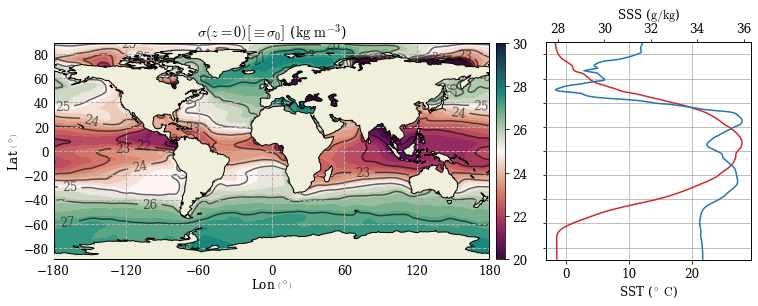

In [267]:
# do a surface plot

# calculate the surface in-situ density (or sigma_0, it's the same)
toce_data = toce.data # load these into memory to save I/O for looping
soce_data = soce.data
plot_data = np.zeros((len(lat), len(lon)))
for j in range(len(lat)):
    plot_data[j, :] = sigmai_dep(toce_data[0, j, :], soce_data[0, j, :], 0)

vmin, vmax = 20, 30

fig = plt.figure(figsize=(12.5, 4))
ax = plt.subplot2grid((1, 3), (0, 0), colspan=2, projection=pcarree)
mesh = ax.contourf(lon, lat, plot_data, levels=np.linspace(vmin, vmax, 30), cmap=cmap, extend="both")
lines = ax.contour(lon, lat, plot_data, levels=np.arange(vmin, vmax+1), 
                   colors="k", alpha=0.6)
ax.clabel(lines, fmt="%i", colors="k")
ax.set_ylim([-89, 89])
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
for c in mesh.collections:
    c.set_edgecolor("face")
gl = ax.gridlines(crs=pcarree,
                  linewidth = 1, linestyle = '--')
gl.ylabels_left = True
gl.xlabels_bottom = True
norm = Normalize(vmin = vmin, vmax = vmax)
colors = cmap(np.linspace(0, 1, cmap.N))
cmap2 = LinearSegmentedColormap.from_list('Upper Half', colors)
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes("right", size = "2%", pad = 0.1, axes_class=plt.Axes)
cb = ColorbarBase(ax_cb, cmap = cmap2, norm = norm)
ax.set_title(r"$\sigma(z=0) [\equiv \sigma_0]$ (${\rm kg\ m^{-3}}$)")
ax.text(-0.075, 0.5, r'Lat $\left( {}^\circ \right)$', 
                    va='bottom', ha='center',
                    rotation=90, rotation_mode='anchor',
                    transform=ax.transAxes)
ax.text(0.5, -0.15, r'Lon $\left( {}^\circ \right)$', 
                   va='bottom', ha='center',
                   rotation='horizontal', rotation_mode='anchor',
                   transform=ax.transAxes)

ax = plt.subplot2grid((1, 3), (0, 2), colspan=1)
lines = ax.plot(np.nanmean(toce[0, :, :], axis=-1), lat, "C3")
ax.set_ylim([-90, 90])
ax.set_xlabel(r"SST (${\rm {}^\circ\ C}$)")
ax.set_yticklabels([])
ax.grid()
ax2 = ax.twiny()
lines = ax2.plot(np.nanmean(soce[0, :, :], axis=-1), lat, "C0")
ax2.set_xlabel(r"SSS (${\rm g/kg}$)")

plt.savefig(f"../lec06/figures/surface_density.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


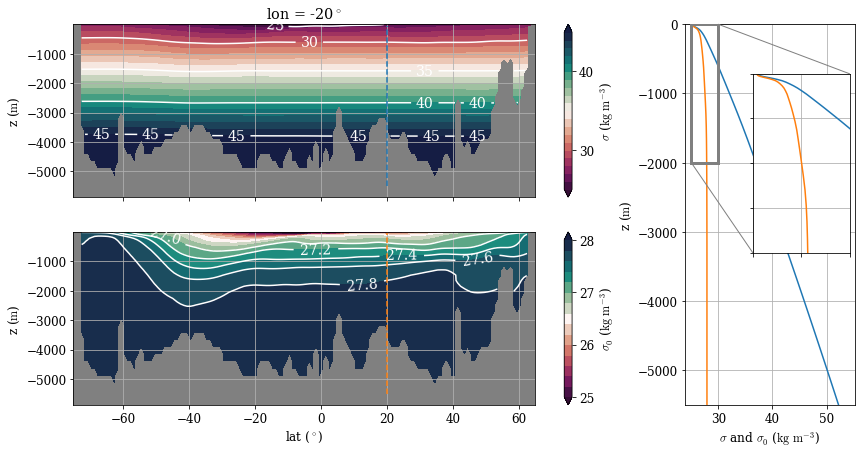

In [265]:
# do a meridional section

# do a plot (Atlantic)
target_lon = -20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
soce_data  = soce.sel(lon=target_lon, method="nearest").data
toce_data  = toce.sel(lon=target_lon, method="nearest").data

sigma0 = np.zeros((len(z), len(lat)))
sigma2 = np.zeros((len(z), len(lat)))
sigma_insitu = np.zeros((len(z), len(lat)))
for j in range(len(lat)):
    sigma_insitu[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], -z)
    sigma0[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 0)
    sigma2[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 2000)

# do a masking based on the GEBCO data
for j in range(len(lat)):
    mask_value = bathy.sel(lon=target_lon, lat=lat[j], method="nearest").data
    sigma_insitu[(z < mask_value), j] = np.nan
    sigma0[(z < mask_value), j] = np.nan
    sigma2[(z < mask_value), j] = np.nan

sigma_opt = {"levels" : np.linspace(25, 28, 16),
             "cmap"   : cmap,
             "extend" : "both",
             }

fig = plt.figure(figsize=(14, 7))
ax = plt.subplot2grid((2, 4), (0, 0), colspan=3)
mesh = ax.contourf(lat, z, sigma_insitu, levels=np.arange(25, 46), cmap=cmap, extend="both")
line = ax.contour(lat, z, sigma_insitu, levels=np.arange(25, 46, 5), colors="w", alpha=1)
ax.clabel(line, fmt = r"%i", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.set_xticklabels([])
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(20, 61, 10))
cax.ax.set_ylabel(r"$\sigma$ (${\rm kg\ m^{-3}}$)")
ax.plot([20, 20], [-5500, -50], color="C0", linestyle='--')

ax = plt.subplot2grid((2, 4), (1, 0), colspan=3)
mesh = ax.contourf(lat, z, sigma0, **sigma_opt)
line = ax.contour(lat, z, sigma0, levels=np.arange(27, 28.6, 0.2), colors="w")
ax.clabel(line, fmt = r"%.1f", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"lat (${}^\circ$)")
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(25, 28.1, 1))
cax.ax.set_ylabel(r"$\sigma_0$ (${\rm kg\ m^{-3}}$)")
ax.plot([20, 20], [-5500, -50], color="C1", linestyle='--')

# plot the vertical profile of density
target_lon = -20.1
target_lat = 20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
actual_lat = soce.sel(lat=target_lat, method="nearest")["lat"].data
soce_data  = soce.sel(lon=target_lon, lat=target_lat, method="nearest").data
toce_data  = toce.sel(lon=target_lon, lat=target_lat, method="nearest").data

sigma_insitu = sigmai_dep(toce_data, soce_data, -z)
sigma0 = sigmai_dep(toce_data, soce_data, 0)

ax = plt.subplot2grid((2, 4), (0, 3), rowspan=2)
ax.plot(sigma_insitu, z, "C0")
ax.plot(sigma0, z, "C1")
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"$\sigma$ and $\sigma_0$ (${\rm kg\ m^{-3}}$)")
ax.set_ylim(-5500, 0)
ax.grid()

axins = ax.inset_axes([0.4, 0.4, 0.57, 0.47])
axins.plot(sigma_insitu, z, "C0")
axins.plot(sigma0, z, "C1")
axins.set_xlim(25, 30)
axins.set_ylim(-2000, 0)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.grid()
ax.indicate_inset_zoom(axins, lw=3, alpha=1)

plt.savefig(f"../lec06/figures/atlantic_density_plot.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


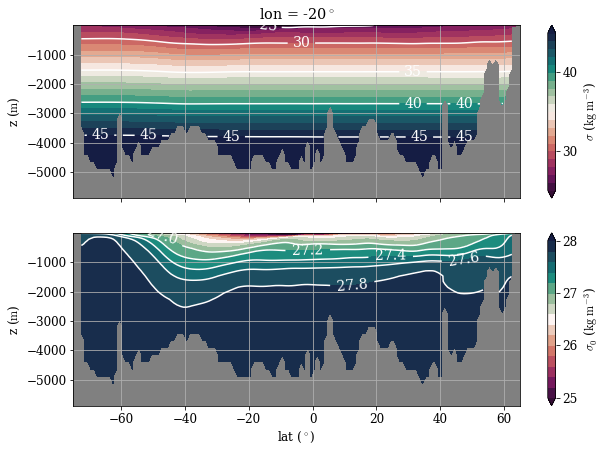

In [261]:
# do a meridional section of sigma and sigma0

# do a plot (Atlantic)
target_lon = -20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
soce_data  = soce.sel(lon=target_lon, method="nearest").data
toce_data  = toce.sel(lon=target_lon, method="nearest").data

sigma0 = np.zeros((len(z), len(lat)))
sigma_insitu = np.zeros((len(z), len(lat)))
for j in range(len(lat)):
    sigma_insitu[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], -z)
    sigma0[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 0)

# do a masking based on the GEBCO data
for j in range(len(lat)):
    mask_value = bathy.sel(lon=target_lon, lat=lat[j], method="nearest").data
    sigma_insitu[(z < mask_value), j] = np.nan
    sigma0[(z < mask_value), j] = np.nan
    sigma2[(z < mask_value), j] = np.nan

sigma_opt = {"levels" : np.linspace(25, 28, 16),
             "cmap"   : cmap,
             "extend" : "both",
             }

fig = plt.figure(figsize=(10, 7))
ax = plt.subplot2grid((2, 1), (0, 0), colspan=3)
mesh = ax.contourf(lat, z, sigma_insitu, levels=np.arange(25, 46), cmap=cmap, extend="both")
line = ax.contour(lat, z, sigma_insitu, levels=np.arange(25, 46, 5), colors="w", alpha=1)
ax.clabel(line, fmt = r"%i", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.set_xticklabels([])
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(20, 61, 10))
cax.ax.set_ylabel(r"$\sigma$ (${\rm kg\ m^{-3}}$)")

ax = plt.subplot2grid((2, 1), (1, 0))
mesh = ax.contourf(lat, z, sigma0, **sigma_opt)
line = ax.contour(lat, z, sigma0, levels=np.arange(27, 28.6, 0.2), colors="w")
ax.clabel(line, fmt = r"%.1f", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"lat (${}^\circ$)")
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(25, 28.1, 1))
cax.ax.set_ylabel(r"$\sigma_0$ (${\rm kg\ m^{-3}}$)")

plt.savefig(f"../lec06/figures/atlantic_density_plot_sigma_0.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


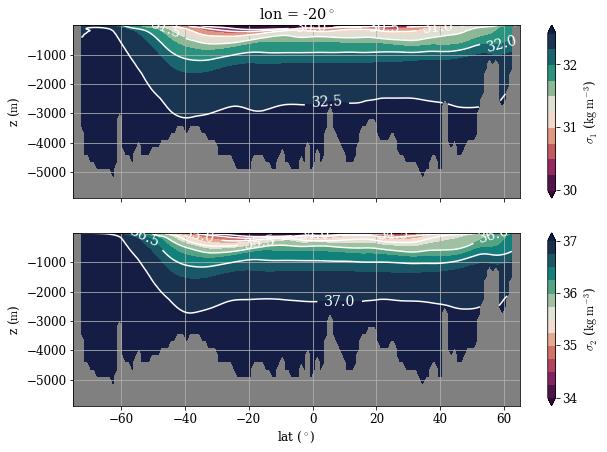

In [262]:
# do a meridional section of sigma1 and sigma2

# do a plot (Atlantic)
target_lon = -20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
soce_data  = soce.sel(lon=target_lon, method="nearest").data
toce_data  = toce.sel(lon=target_lon, method="nearest").data

sigma1 = np.zeros((len(z), len(lat)))
sigma2 = np.zeros((len(z), len(lat)))
for j in range(len(lat)):
    sigma1[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 1000)
    sigma2[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 2000)

# do a masking based on the GEBCO data
for j in range(len(lat)):
    mask_value = bathy.sel(lon=target_lon, lat=lat[j], method="nearest").data
    sigma1[(z < mask_value), j] = np.nan
    sigma2[(z < mask_value), j] = np.nan

fig = plt.figure(figsize=(10, 7))
ax = plt.subplot2grid((2, 1), (0, 0), colspan=3)
mesh = ax.contourf(lat, z, sigma1, levels=np.arange(30, 32.6, 0.25), cmap=cmap, extend="both")
line = ax.contour(lat, z, sigma1, levels=np.arange(30, 32.6, 0.5), colors="w", alpha=1)
ax.clabel(line, fmt = r"%.1f", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.set_xticklabels([])
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(28, 33, 1))
cax.ax.set_ylabel(r"$\sigma_1$ (${\rm kg\ m^{-3}}$)")

ax = plt.subplot2grid((2, 1), (1, 0))
mesh = ax.contourf(lat, z, sigma2, levels=np.arange(34, 37.1, 0.25), cmap=cmap, extend="both")
line = ax.contour(lat, z, sigma2, levels=np.arange(34, 37.1, 0.5), colors="w")
ax.clabel(line, fmt = r"%.1f", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"lat (${}^\circ$)")
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(31, 37.1, 1))
cax.ax.set_ylabel(r"$\sigma_2$ (${\rm kg\ m^{-3}}$)")

plt.savefig(f"../lec06/figures/atlantic_density_plot_sigma_12.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


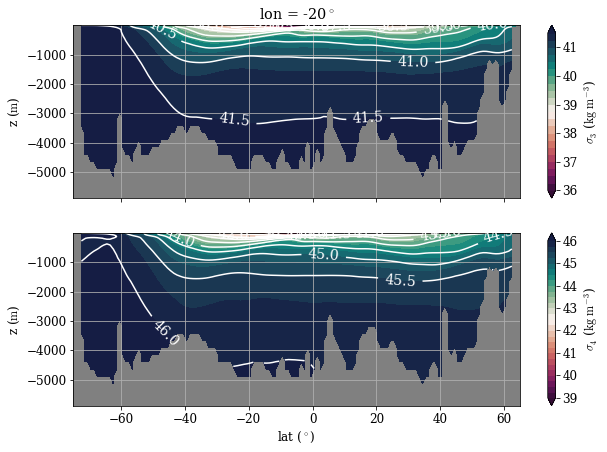

In [263]:
# do a meridional section of sigma3 and sigma4

# do a plot (Atlantic)
target_lon = -20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
soce_data  = soce.sel(lon=target_lon, method="nearest").data
toce_data  = toce.sel(lon=target_lon, method="nearest").data

sigma3 = np.zeros((len(z), len(lat)))
sigma4 = np.zeros((len(z), len(lat)))
for j in range(len(lat)):
    sigma3[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 3000)
    sigma4[:, j] = sigmai_dep(toce_data[:, j], soce_data[:, j], 4000)

# do a masking based on the GEBCO data
for j in range(len(lat)):
    mask_value = bathy.sel(lon=target_lon, lat=lat[j], method="nearest").data
    sigma3[(z < mask_value), j] = np.nan
    sigma4[(z < mask_value), j] = np.nan

fig = plt.figure(figsize=(10, 7))
ax = plt.subplot2grid((2, 1), (0, 0), colspan=3)
mesh = ax.contourf(lat, z, sigma3, levels=np.arange(36, 41.6, 0.25), cmap=cmap, extend="both")
line = ax.contour(lat, z, sigma3, levels=np.arange(36, 41.6, 0.5), colors="w", alpha=1)
ax.clabel(line, fmt = r"%.1f", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.set_xticklabels([])
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(36, 42, 1))
cax.ax.set_ylabel(r"$\sigma_3$ (${\rm kg\ m^{-3}}$)")

ax = plt.subplot2grid((2, 1), (1, 0))
mesh = ax.contourf(lat, z, sigma4, levels=np.arange(39, 46.1, 0.25), cmap=cmap, extend="both")
line = ax.contour(lat, z, sigma4, levels=np.arange(39, 46.1, 0.5), colors="w")
ax.clabel(line, fmt = r"%.1f", colors="w", fontsize=14)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"lat (${}^\circ$)")
ax.grid()
ax.set_facecolor('gray')
cax = plt.colorbar(mesh)
cax.set_ticks(np.arange(39, 46.1, 1))
cax.ax.set_ylabel(r"$\sigma_4$ (${\rm kg\ m^{-3}}$)")

plt.savefig(f"../lec06/figures/atlantic_density_plot_sigma_34.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


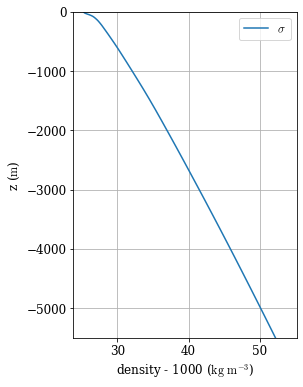

In [4]:
# plot the vertical profile of density
target_lon = -20.1
target_lat = 20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
actual_lat = soce.sel(lat=target_lat, method="nearest")["lat"].data
soce_data  = soce.sel(lon=target_lon, lat=target_lat, method="nearest").data
toce_data  = toce.sel(lon=target_lon, lat=target_lat, method="nearest").data

sigma_insitu = sigmai_dep(toce_data, soce_data, -z)
sigma0 = sigmai_dep(toce_data, soce_data, 0)

fig = plt.figure(figsize=(4, 6))
ax = plt.axes()
ax.plot(sigma_insitu, z, "C0", label=r"$\sigma$")
# ax.plot(sigma0, z, "C1", label=r"$\sigma_0$")
ax.legend()
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"density - 1000 (${\rm kg\ m^{-3}}$)")
ax.set_ylim(-5500, 0)
ax.grid()

plt.savefig(f"../lec06/figures/sigma_insitu_vert.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


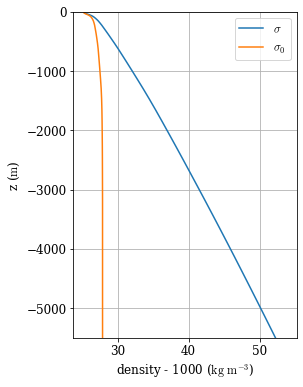

In [5]:
# plot the vertical profile of sigma0
target_lon = -20.1
target_lat = 20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
actual_lat = soce.sel(lat=target_lat, method="nearest")["lat"].data
soce_data  = soce.sel(lon=target_lon, lat=target_lat, method="nearest").data
toce_data  = toce.sel(lon=target_lon, lat=target_lat, method="nearest").data

sigma_insitu = sigmai_dep(toce_data, soce_data, -z)
sigma0 = sigmai_dep(toce_data, soce_data, 0)

fig = plt.figure(figsize=(4, 6))
ax = plt.axes()
ax.plot(sigma_insitu, z, "C0", label=r"$\sigma$")
ax.plot(sigma0, z, "C1", label=r"$\sigma_0$")
ax.legend()
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"density - 1000 (${\rm kg\ m^{-3}}$)")
ax.set_ylim(-5500, 0)
ax.grid()

plt.savefig(f"../lec06/figures/sigma0_vert.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


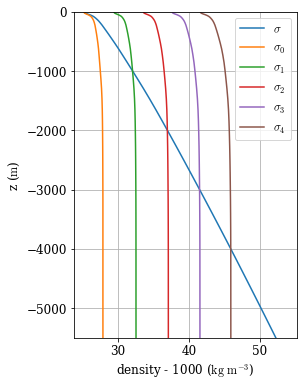

In [5]:
# plot the vertical profile of sigmas
target_lon = -20.1
target_lat = 20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
actual_lat = soce.sel(lat=target_lat, method="nearest")["lat"].data
soce_data  = soce.sel(lon=target_lon, lat=target_lat, method="nearest").data
toce_data  = toce.sel(lon=target_lon, lat=target_lat, method="nearest").data

sigma_insitu = sigmai_dep(toce_data, soce_data, -z)
sigma0 = sigmai_dep(toce_data, soce_data, 0)
sigma1 = sigmai_dep(toce_data, soce_data, 1000)
sigma2 = sigmai_dep(toce_data, soce_data, 2000)
sigma3 = sigmai_dep(toce_data, soce_data, 3000)
sigma4 = sigmai_dep(toce_data, soce_data, 4000)

fig = plt.figure(figsize=(4, 6))
ax = plt.axes()
ax.plot(sigma_insitu, z, "C0", label=r"$\sigma$")
ax.plot(sigma0, z, "C1", label=r"$\sigma_0$")
ax.plot(sigma1, z, "C2", label=r"$\sigma_1$")
ax.plot(sigma2, z, "C3", label=r"$\sigma_2$")
ax.plot(sigma3, z, "C4", label=r"$\sigma_3$")
ax.plot(sigma4, z, "C5", label=r"$\sigma_4$")
ax.legend()
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"density - 1000 (${\rm kg\ m^{-3}}$)")
ax.set_ylim(-5500, 0)
ax.grid()

# plt.savefig(f"../lec06/figures/sigma0124_vert.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")

outputted files


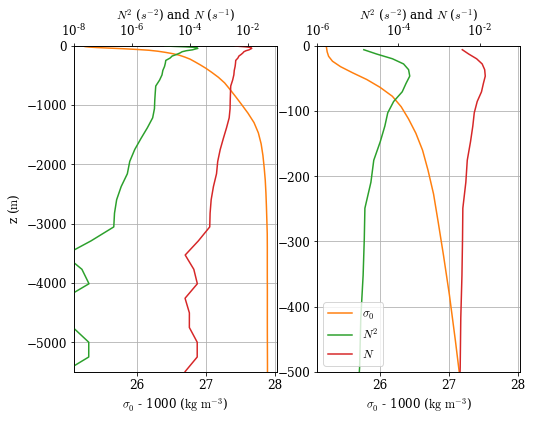

In [98]:
# plot the vertical profile of sigma and N^2
target_lon = -20.1
target_lat = 20.1
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].data
actual_lat = soce.sel(lat=target_lat, method="nearest")["lat"].data
soce_data  = soce.sel(lon=target_lon, lat=target_lat, method="nearest").data
toce_data  = toce.sel(lon=target_lon, lat=target_lat, method="nearest").data

sigma0 = sigmai_dep(toce_data, soce_data, 0)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(sigma0, z, "C1", label=r"$\sigma_0$")
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"$\sigma_0$ - 1000 (${\rm kg\ m^{-3}}$)")
ax.set_ylim(-5500, 0)
ax.grid()

# multiple cheats with this computation here (the abs and interp)
N2 = 9.8 / 1026.0 * np.abs((np.diff(sigma0) / np.diff(z)))
z_mid = 0.5 * (z[1::] + z[0:-1:1])
from scipy.interpolate import interp1d
idz = np.nonzero(N)
N2_int = interp1d(z_mid[idz], N2[idz], fill_value="extrapolate")

ax2 = ax.twiny()
ax2.semilogx(np.abs(N2_int(z_mid)), z_mid, "C2", label=r"$N^2$")
ax2.semilogx(np.sqrt(np.abs(N2_int(z_mid))), z_mid, "C3", label=r"$N$")
ax2.set_xlim(1e-8, 1e-1)
ax2.set_ylim(-5500, 0)
ax2.set_xlabel(r"$N^2$ ($s^{-2}$) and $N$ ($s^{-1}$)")

ax = plt.subplot(1, 2, 2)
line1 = ax.plot(sigma0, z, "C1", label=r"$\sigma_0$")
ax.set_xlabel(r"$\sigma_0$ - 1000 (${\rm kg\ m^{-3}}$)")
ax.set_ylim(-500, 0)
ax.grid()
ax2 = ax.twiny()
line2 = ax2.semilogx(np.abs(N2_int(z_mid)), z_mid, "C2", label=r"$N^2$")
line3 = ax2.semilogx(np.sqrt(np.abs(N2_int(z_mid))), z_mid, "C3", label=r"$N$")
ax2.set_xlim(1e-6, 1e-1)
ax2.set_ylim(-500, 0)
ax2.set_xlabel(r"$N^2$ ($s^{-2}$) and $N$ ($s^{-1}$)")

lines = line1 + line2 + line3
labs = [l.get_label() for l in lines]
ax2.legend(lines, labs, loc=3)

plt.savefig(f"../lec16/figures/sigma0_N2_vert.png", dpi = 150, bbox_inches = "tight")
    
print("outputted files")